## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
import matplotlib as mpl
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

## 1. Carga datos y representa la serie

In [7]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates = ['date']) #esta columna es de date
df.head()

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
print(df.head())

            value  year  month  day
date                               
1949-01-01    112  1949      1    1
1949-02-01    118  1949      2    1
1949-03-01    132  1949      3    1
1949-04-01    129  1949      4    1
1949-05-01    121  1949      5    1


In [9]:
print(df.index.dtype)

datetime64[ns]


In [11]:
print("Desde que fecha a que fecha:")
print(df.index.min().strftime('%Y-%m-%d'), "hasta", df.index.max().strftime('%Y-%m-%d'))

Desde que fecha a que fecha:
1949-01-01 hasta 1960-12-01


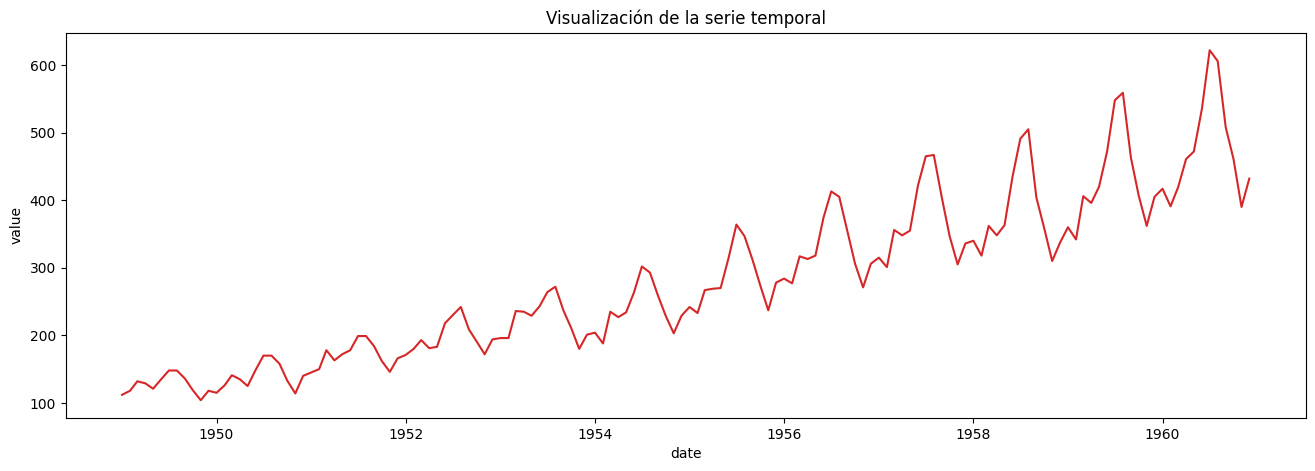

In [12]:
def plot_df(df, x, y, title="", xlabel='date', ylabel='value', dpi=100):
   plt.figure(figsize=(16,5), dpi=dpi)
   plt.plot(x, y, color='tab:red')
   plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
   plt.show()
plot_df(df, x=df.index, y=df.value, 
       title='Visualización de la serie temporal')

<Figure size 1920x600 with 0 Axes>

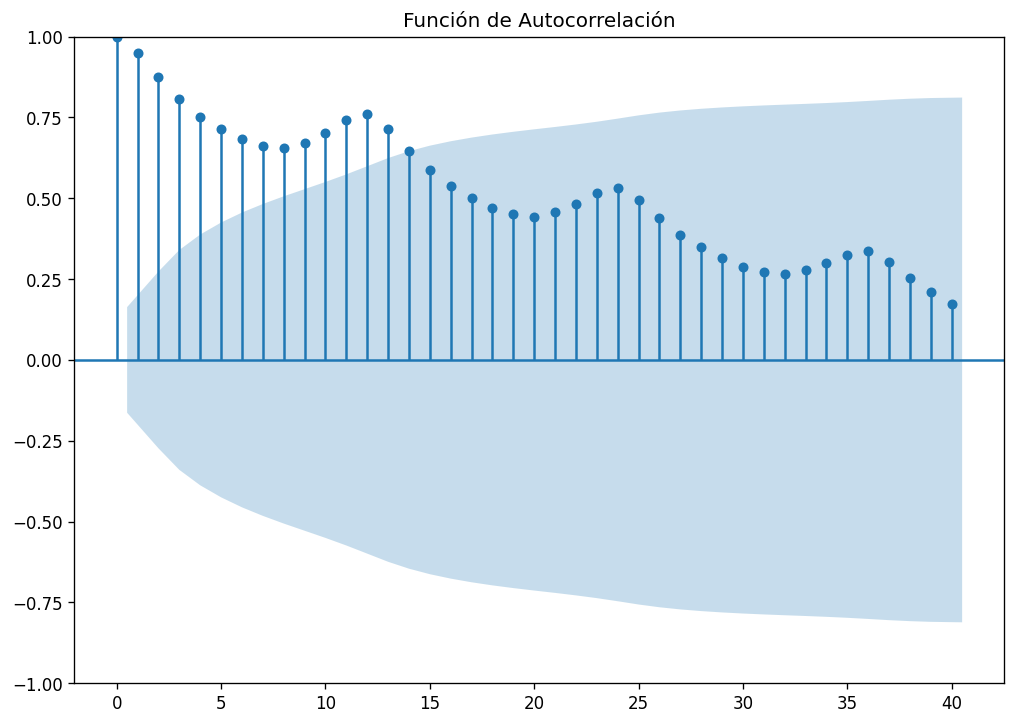

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(16,5))
plot_acf(df.value, lags=40)
plt.title('Función de Autocorrelación')
plt.show()

Si, si hay estacionalidad debido a que se observan patrones que se repiten cada 12 meses.

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

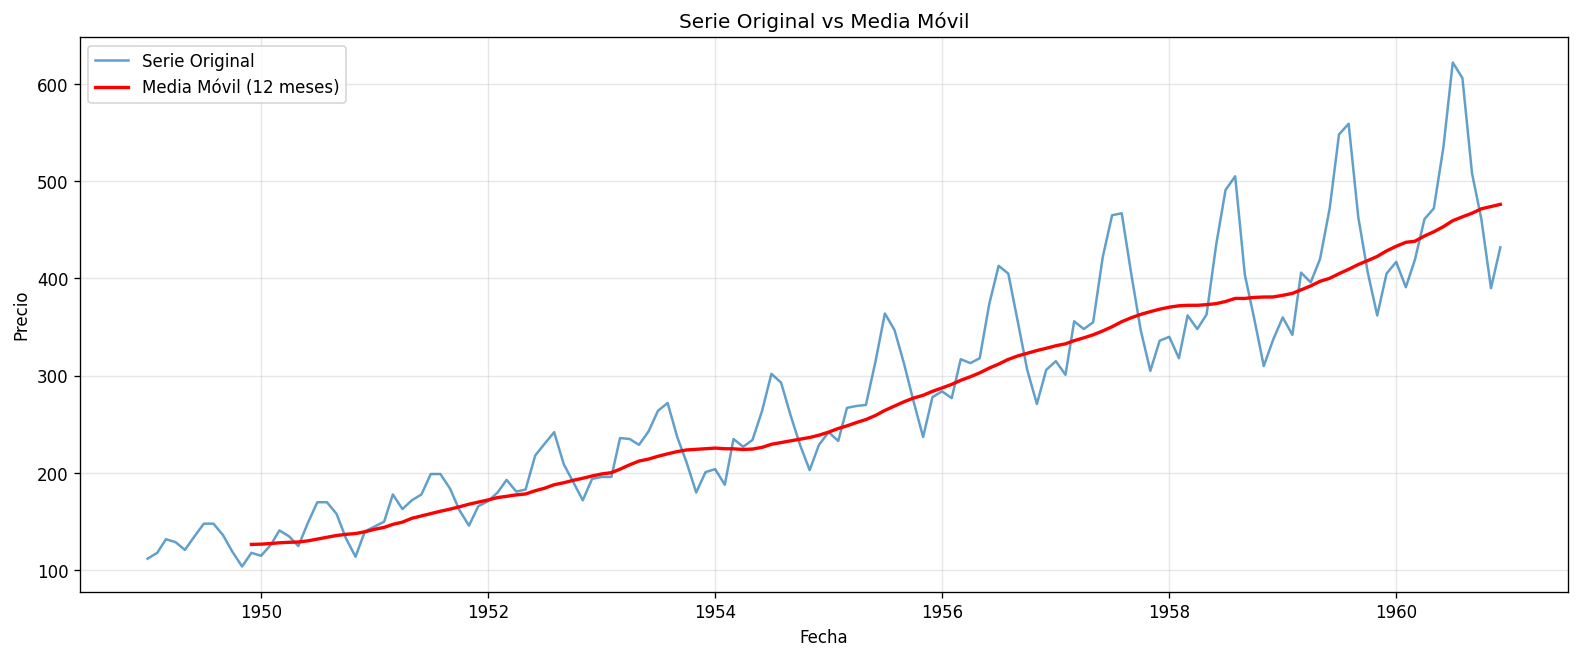

In [14]:
#Primeramente, vamos a calcular la media móvil con ventana de 12 meses
rolling_mean = df.value.rolling(window=12).mean() 
#Al realizar esto, se van a suavizar las fluctuaciones.

plt.figure(figsize=(16,6))

#Vamos a dibujar la serie original
plt.plot(df.index, df.value, label='Serie Original', alpha=0.7)

#Ahora vamos a proceder a dibujar la media móvil
plt.plot(df.index, rolling_mean, label='Media Móvil (12 meses)', 
         color='red', linewidth=2)

plt.title('Serie Original vs Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Comprueba de manera estadística si la serie es o no stationary.

Resultados del Test:
Estadístico del Test         0.815369
p-value                      0.991880
Lags usados                 13.000000
Número de observaciones    130.000000
Valor Crítico (1%)          -3.481682
Valor Crítico (5%)          -2.884042
Valor Crítico (10%)         -2.578770
dtype: float64

La serie NO es estacionaria (p-value > 0.05)


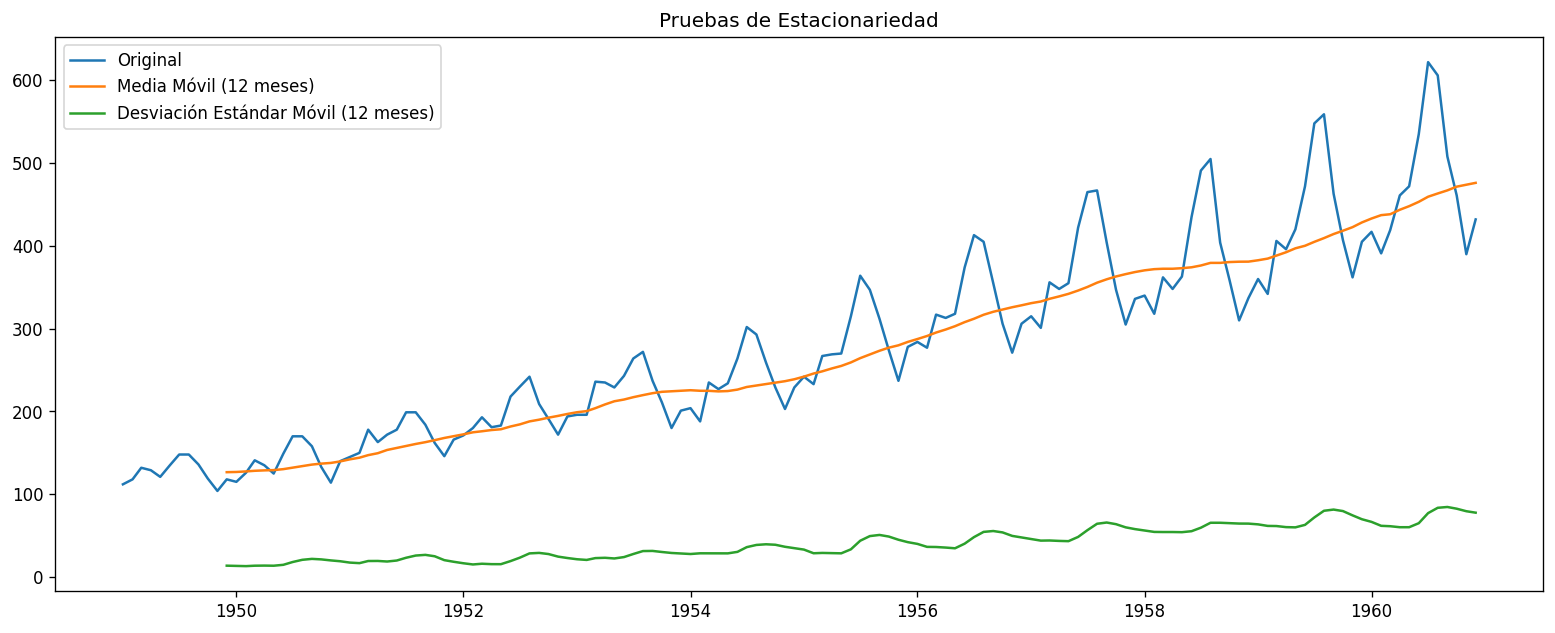

In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=12):
    #Para ello, podemos emplear el Test de Dickey-Fuller
    print('Resultados del Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Organizamos los resultados en un diccionario
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico del Test',
                                            'p-value',
                                            'Lags usados',
                                            'Número de observaciones'])
    
    for key, value in dftest[4].items():
        dfoutput[f'Valor Crítico ({key})'] = value
    
    print(dfoutput)
    
    # Conclusión basada en el p-value
    if dftest[1] > 0.05:
        print("\nLa serie NO es estacionaria (p-value > 0.05)")
    else:
        print("\nLa serie es estacionaria (p-value < 0.05)")
    
    # Visualizamos la media y la varianza móvil
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    plt.figure(figsize=(16,6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label=f'Media Móvil ({window} meses)')
    plt.plot(rolling_std, label=f'Desviación Estándar Móvil ({window} meses)')
    plt.title('Pruebas de Estacionariedad')
    plt.legend()
    plt.show()

# Aplicamos el test a nuestra serie
test_stationarity(df.value)

Para ello, podemos realizar el test de Dickey-Fuller:

* H0 (Significa la Hipótesis Nula): Es decir, para este caso, la serie no es estacionaria.

* H1 (Significa la Hipótesis Alternativa): En este caso, la serie es estacionaria.

Para ello, podemos identificarlo mejor empleando para ello el p-value:

* Si p-value > 0.05: No debemos rechazar la Hipótesis Nula, la serie en este caso, no sería estacionaria.

* Si p-value < 0.05: Rechazamos lo que es la Hipótesis Nula, la serie entonces es estacionaria.

Podemos seguir haciendo un estudio:

Una serie es estacionaría si presenta una media y varianza constantes en el tiempo.

## 4. Aplica una transformación logarítmica

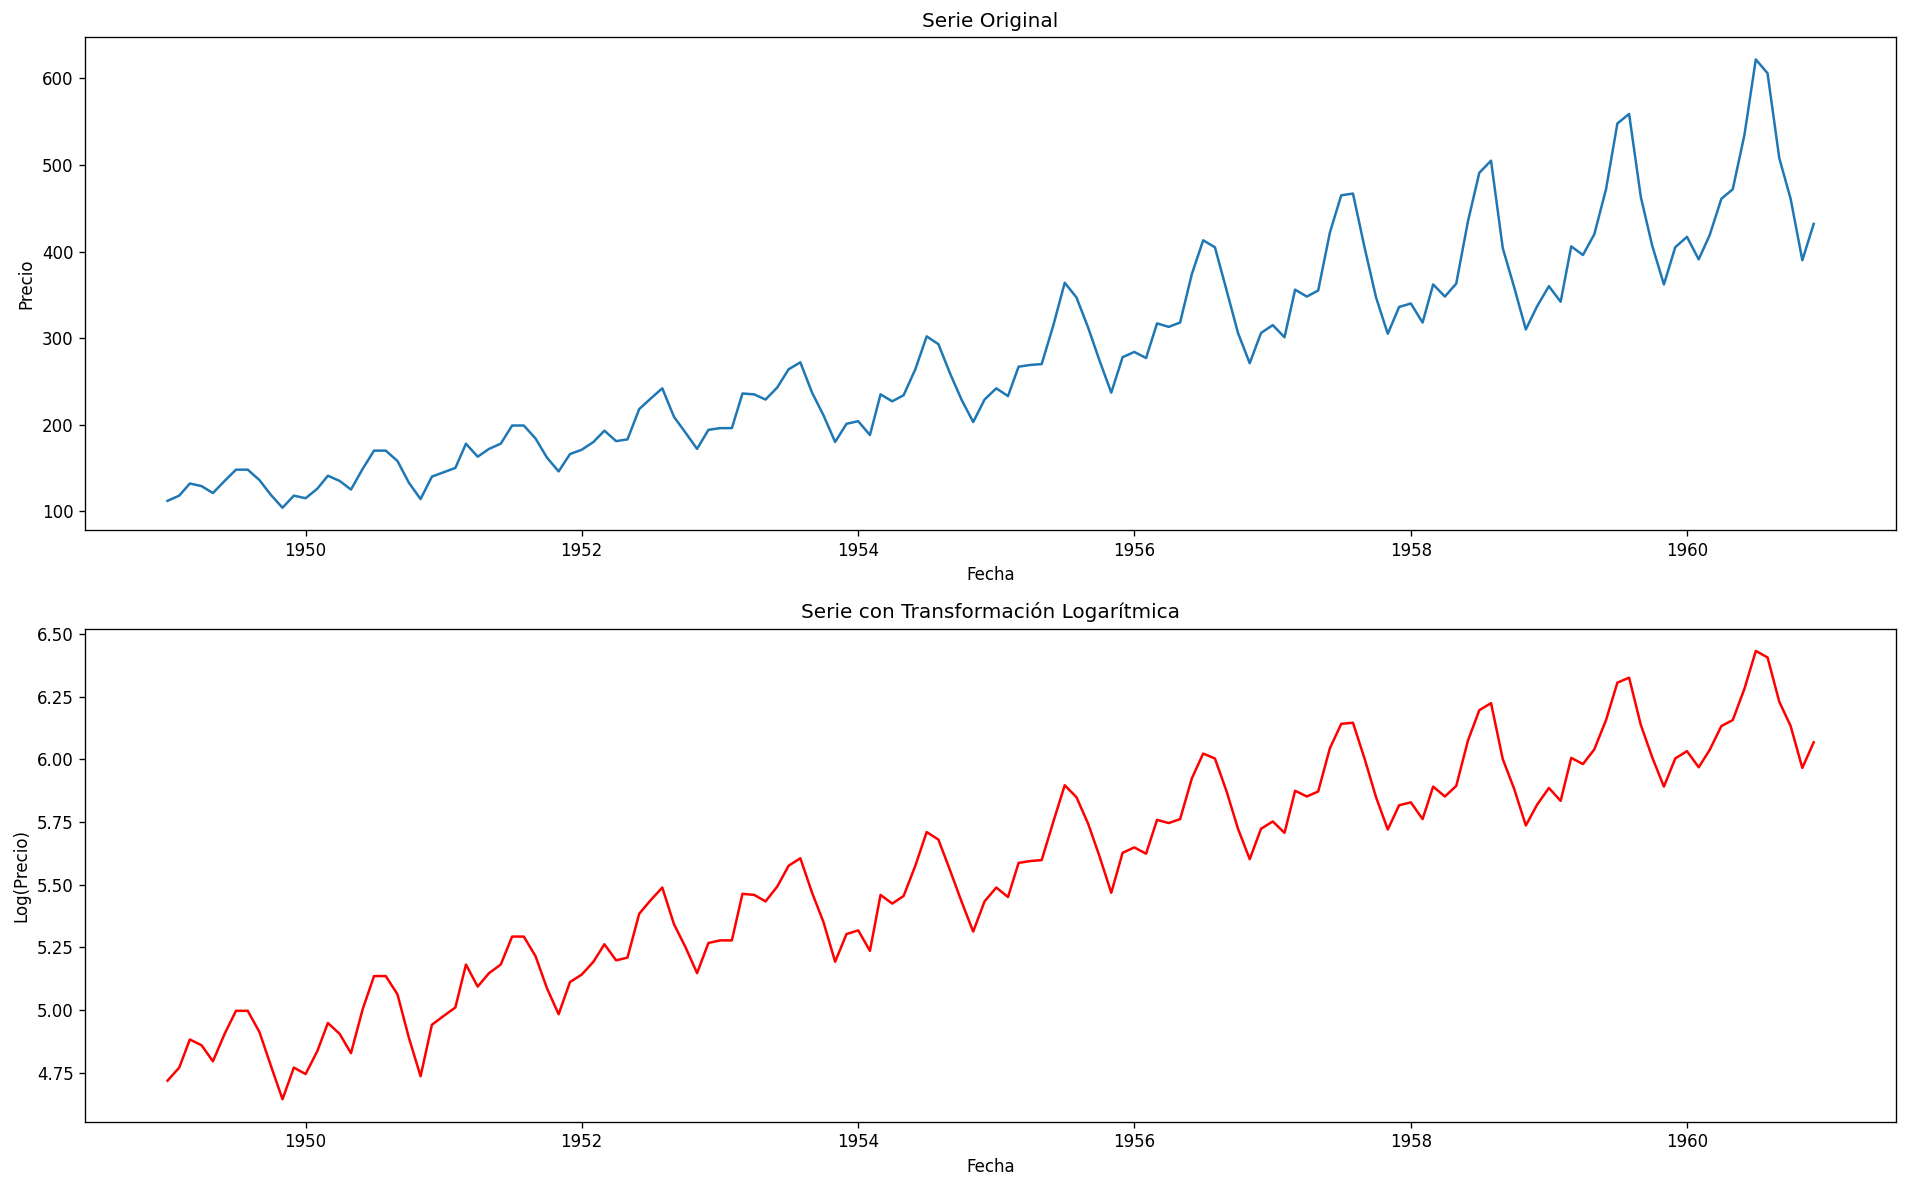


Resultados del Test de Dickey-Fuller para Original:
Estadístico del Test         0.815369
p-value                      0.991880
Lags usados                 13.000000
Número de observaciones    130.000000
Valor Crítico (1%)          -3.481682
Valor Crítico (5%)          -2.884042
Valor Crítico (10%)         -2.578770
dtype: float64

Conclusión: La serie Original NO es estacionaria (p-value > 0.05)

Resultados del Test de Dickey-Fuller para Transformada:
Estadístico del Test        -1.717017
p-value                      0.422367
Lags usados                 13.000000
Número de observaciones    130.000000
Valor Crítico (1%)          -3.481682
Valor Crítico (5%)          -2.884042
Valor Crítico (10%)         -2.578770
dtype: float64

Conclusión: La serie Transformada NO es estacionaria (p-value > 0.05)


In [17]:
# Aplicamos en este apartado una transformación logarítmica
df['log_price'] = np.log(df.value)

# Visualizamos la serie original vs la transformada
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Serie Original
ax1.plot(df.index, df.value)
ax1.set_title('Serie Original')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio')

#Dibujamos la serie con transformación logarítmica
ax2.plot(df.index, df.log_price, color='red')
ax2.set_title('Serie con Transformación Logarítmica')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Log(Precio)')

plt.tight_layout()
plt.show()

# Comprobamos si la serie transformada es más estacionaria
def test_stationarity(timeseries, title):
    #Realizamos una vez más, el test de Dickey-Fuller
    print(f'\nResultados del Test de Dickey-Fuller para {title}:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico del Test',
                                            'p-value',
                                            'Lags usados',
                                            'Número de observaciones'])
    
    for key, value in dftest[4].items():
        dfoutput[f'Valor Crítico ({key})'] = value
    
    print(dfoutput)
    
    if dftest[1] > 0.05:
        print(f"\nConclusión: La serie {title} NO es estacionaria (p-value > 0.05)")
    else:
        print(f"\nConclusión: La serie {title} es estacionaria (p-value < 0.05)")

# Testeamos ambas series
test_stationarity(df.value, "Original")
test_stationarity(df.log_price, "Transformada")

## 5. Divide en train y test. Guarda 20 muestras para test.

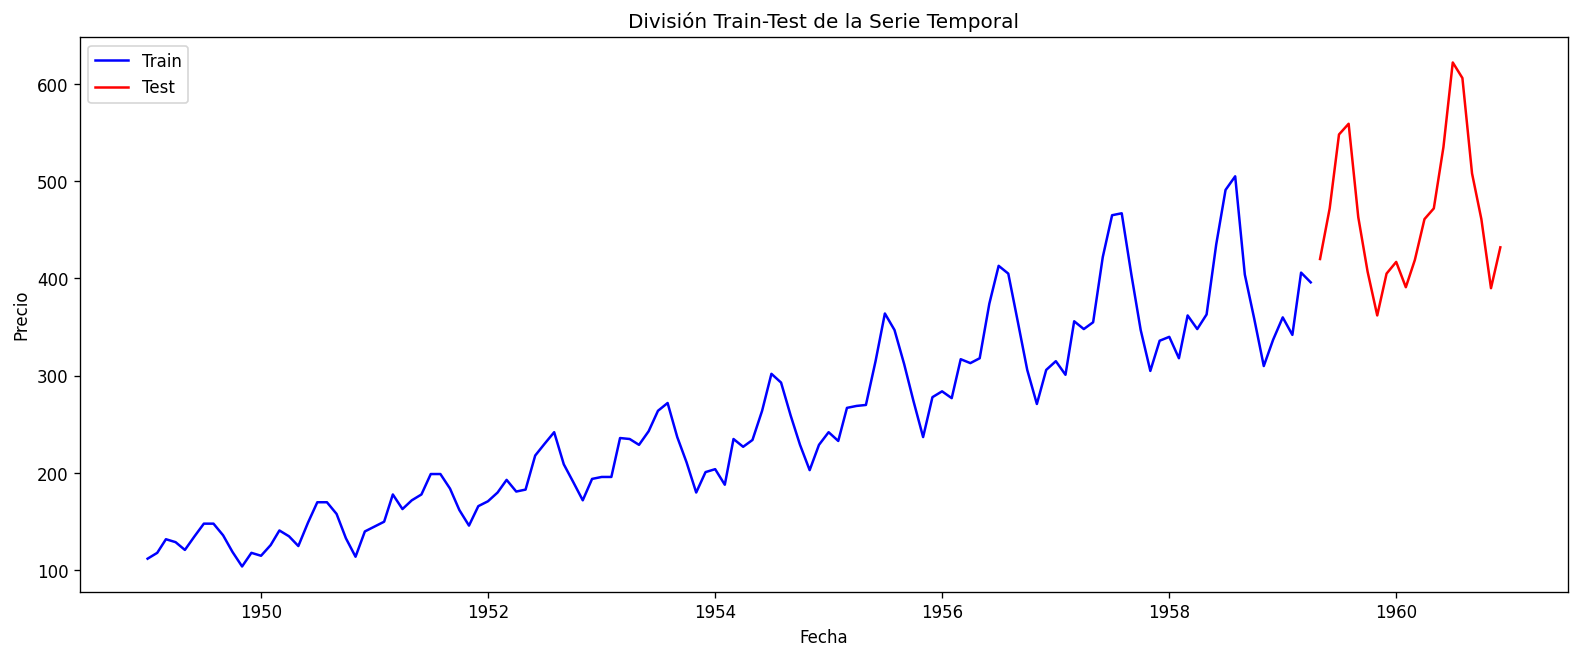

Información sobre la división:
Tamaño total de la serie: 144
Tamaño del conjunto de train: 124
Tamaño del conjunto de test: 20

Rango de fechas:
Train: desde 1949-01-01 00:00:00 hasta 1959-04-01 00:00:00
Test: desde 1959-05-01 00:00:00 hasta 1960-12-01 00:00:00


In [19]:
#Añadimos el punto de división
n_test = 20
split_point = len(df) - n_test

# Dividimos los datos en train y en test
train = df[:split_point]
test = df[split_point:]

# Visualizamos a continuación la división
plt.figure(figsize=(16,6))
plt.plot(train.index, train.value, label='Train', color='blue')
plt.plot(test.index, test.value, label='Test', color='red')
plt.title('División Train-Test de la Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

# Mostramos información sobre los conjuntos
print("Información sobre la división:")
print(f"Tamaño total de la serie: {len(df)}")
print(f"Tamaño del conjunto de train: {len(train)}")
print(f"Tamaño del conjunto de test: {len(test)}")
print("\nRango de fechas:")
print(f"Train: desde {train.index.min()} hasta {train.index.max()}")
print(f"Test: desde {test.index.min()} hasta {test.index.max()}")

# También guardamos la versión logarítmica
train_log = train['log_price']
test_log = test['log_price']

## 6. Crea tu primer modelo ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=840.999, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=838.710, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=839.471, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=837.876, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=838.989, Time=0.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=839.344, Time=0.39 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=839.199, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=838.427, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=841.152, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=839.642, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 3.531 seconds

Resumen del modelo:
                                     SARIMAX Results                                      
Dep. Variable:                               

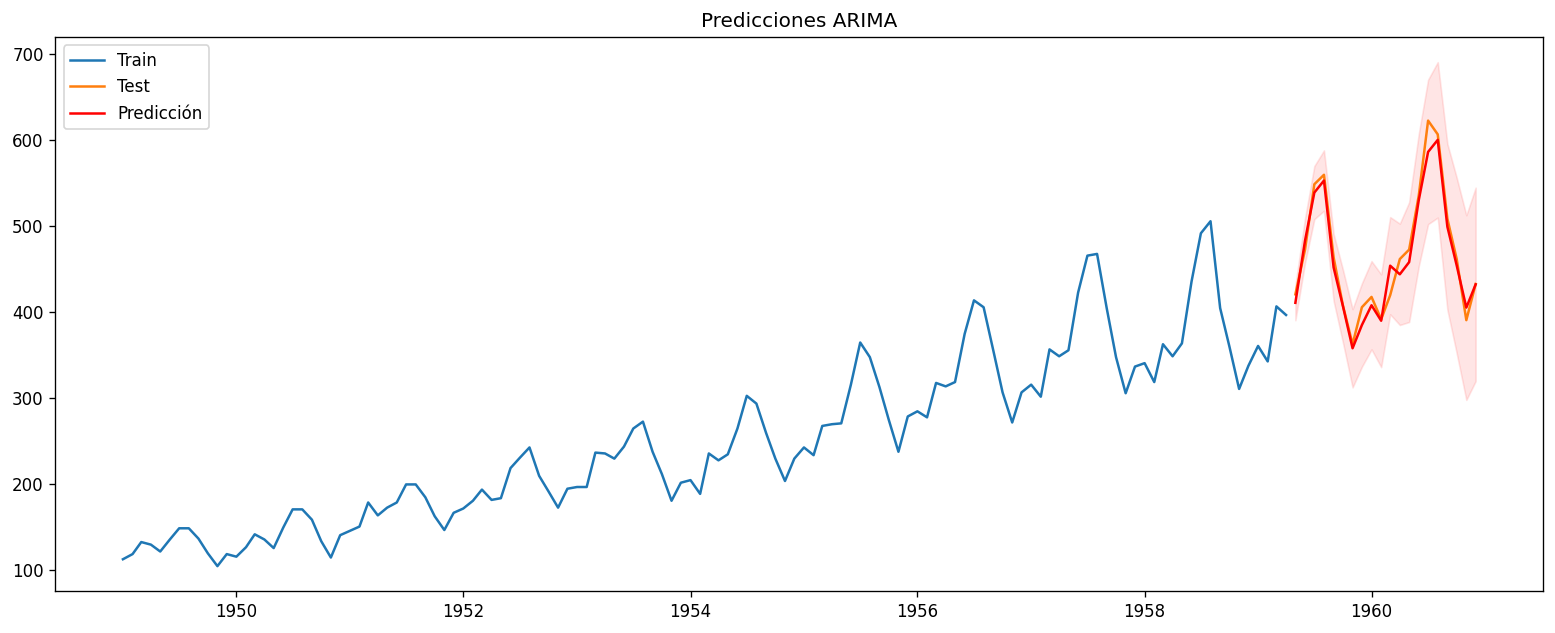

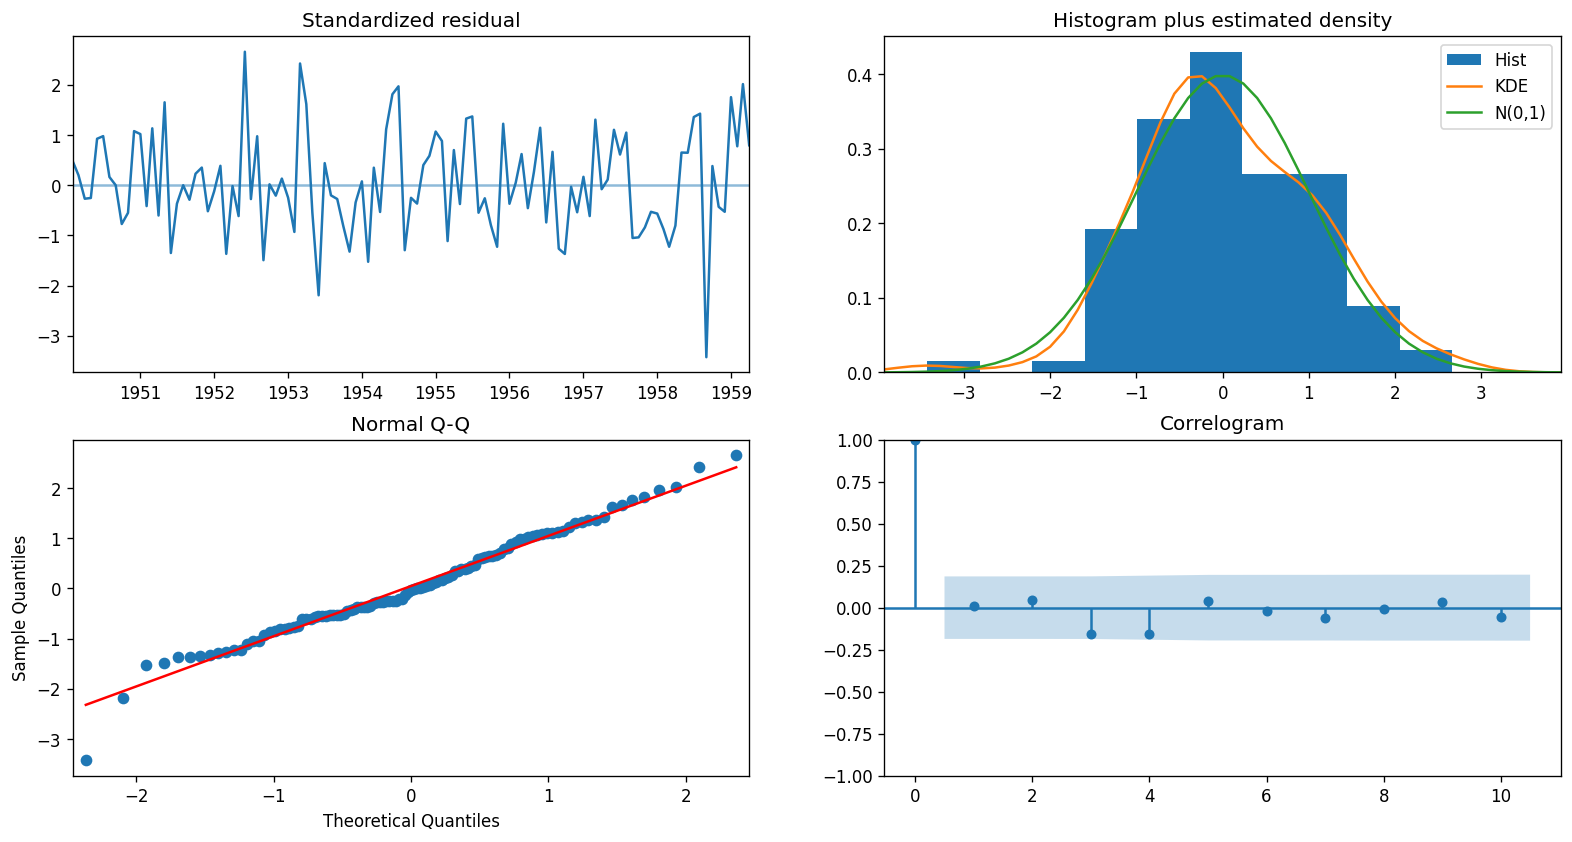

In [20]:
#Vamos a realizar a continuación un modelo ARIMA

import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Entrenamos el modelo auto_arima
model = pm.auto_arima(train.value,
                     seasonal=True,  # Consideramos estacionalidad
                     m=12,          # Período estacional = 12 meses
                     start_p=0, start_q=0, # Valores iniciales para p y q
                     max_p=3, max_q=3,     # Valores máximos para p y q
                     start_P=0, start_Q=0, # Valores iniciales para P y Q estacionales
                     max_P=2, max_Q=2,     # Valores máximos para P y Q estacionales
                     d=1, D=1,             # Diferenciación
                     trace=True,           # Muestra el progreso
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)

# Resumimos del modelo
print("\nResumen del modelo:")
print(model.summary())

#Realizamos predicciones a continuación
n_periods = len(test)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

#Calculamos métricas de error
mae = mean_absolute_error(test.value, forecast)
rmse = np.sqrt(mean_squared_error(test.value, forecast))

print(f"\nMétricas de evaluación:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

#Visualizamos las predicciones
plt.figure(figsize=(16,6))
plt.plot(train.index, train.value, label='Train')
plt.plot(test.index, test.value, label='Test')
plt.plot(test.index, forecast, label='Predicción', color='red')
plt.fill_between(test.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='red', 
                 alpha=0.1)
plt.title('Predicciones ARIMA')
plt.legend()
plt.show()

#Diagnóstico del modelo
model.plot_diagnostics(figsize=(16,8))
plt.show()

## 7. Representa en una gráfica los datos de test y tus predicciones.

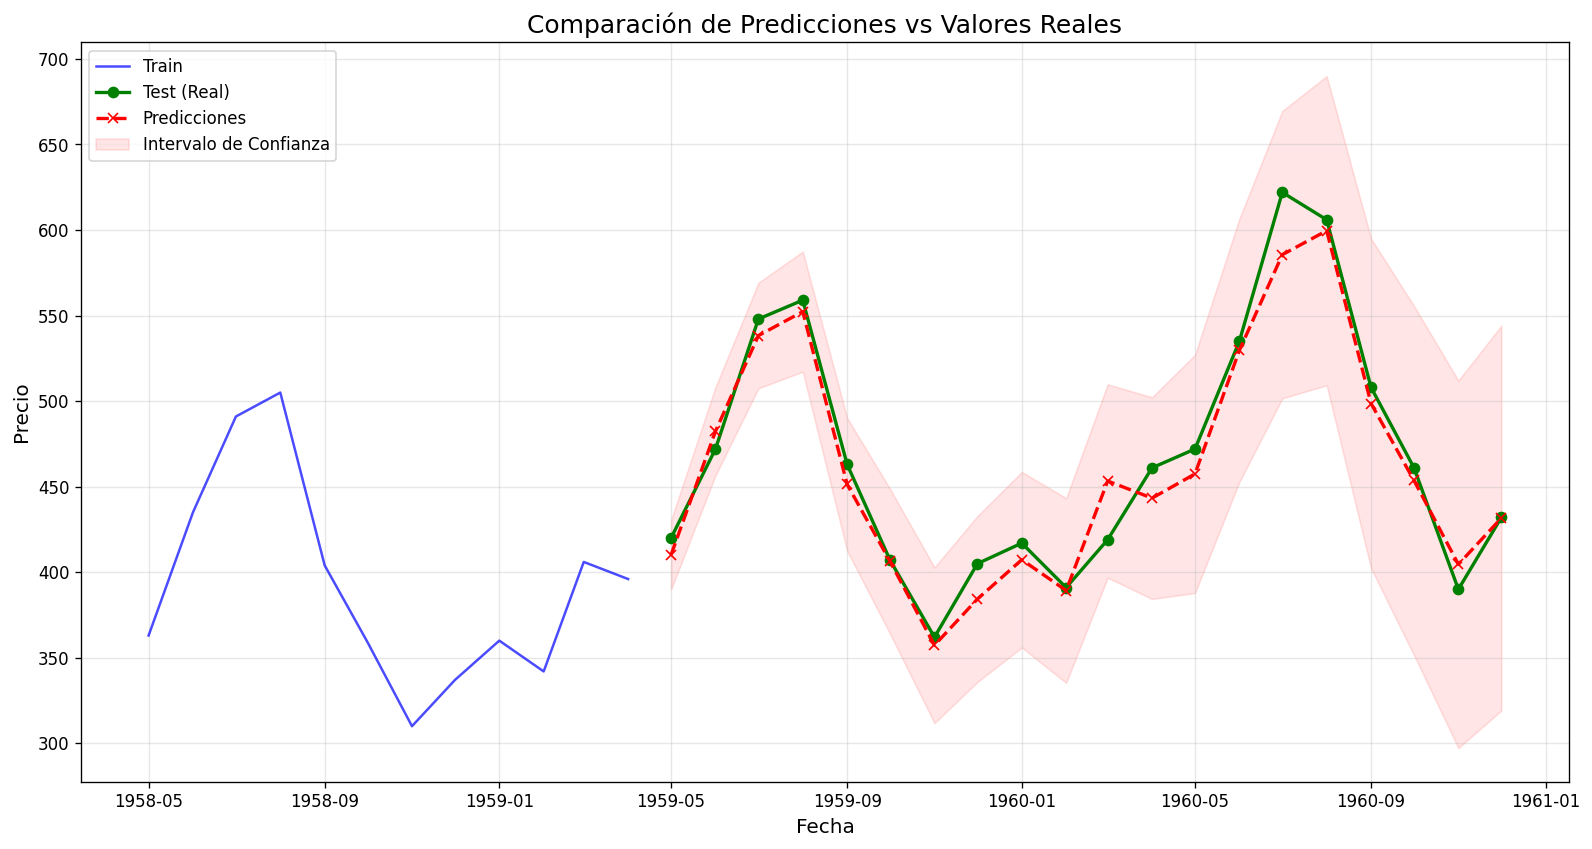


Métricas de Error:
Error Absoluto Medio (MAE): 11.61
Error Cuadrático Medio (RMSE): 14.97
Error Porcentual Medio Absoluto (MAPE): 2.48%

Comparación detallada de los últimos 5 puntos:
            Valor Real  Predicción  Error Absoluto
1960-08-01         606  599.603549        6.396451
1960-09-01         508  498.601847        9.398153
1960-10-01         461  453.602208        7.397792
1960-11-01         390  404.602131       14.602131
1960-12-01         432  431.602148        0.397852


In [21]:
plt.figure(figsize=(16,8))

# Datos de entrenamiento (últimos puntos)
plt.plot(train.index[-12:], train.value[-12:], 
         label='Train', color='blue', alpha=0.7)

# Datos del test
plt.plot(test.index, test.value, 
         label='Test (Real)', color='green', 
         marker='o', linestyle='-', linewidth=2)

plt.plot(test.index, forecast, 
         label='Predicciones', color='red', 
         marker='x', linestyle='--', linewidth=2)

# Intervalo de confianza
plt.fill_between(test.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='red', 
                 alpha=0.1,
                 label='Intervalo de Confianza')

# Personalizamos la gráfica
plt.title('Comparación de Predicciones vs Valores Reales', fontsize=15)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Mostramos la gráfica
plt.show()

# Mostramos métricas de error
print("\nMétricas de Error:")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (RMSE): {rmse:.2f}")

# Calculamos el error porcentual medio absoluto (MAPE)
mape = np.mean(np.abs((test.value - forecast) / test.value)) * 100
print(f"Error Porcentual Medio Absoluto (MAPE): {mape:.2f}%")

# Tabla de comparación
comparison = pd.DataFrame({
    'Valor Real': test.value.values,
    'Predicción': forecast,
    'Error Absoluto': np.abs(test.value.values - forecast)
})
print("\nComparación detallada de los últimos 5 puntos:")
print(comparison.tail())

## 8. Prueba otros modelos, a ver qué performance presentan.

He realizado una prueba empleando el modelo de Decision Tree Regressor. --> Es un método muy simple pero tengo ya el aviso de que puede llegar a ser inestable.

Shapes de los datos:
X_train: (112, 12)
y_train: (112,)
X_test: (8, 12)
y_test: (8,)

Métricas Decision Tree:
MAE: 38.88
RMSE: 57.32
R2: 0.43


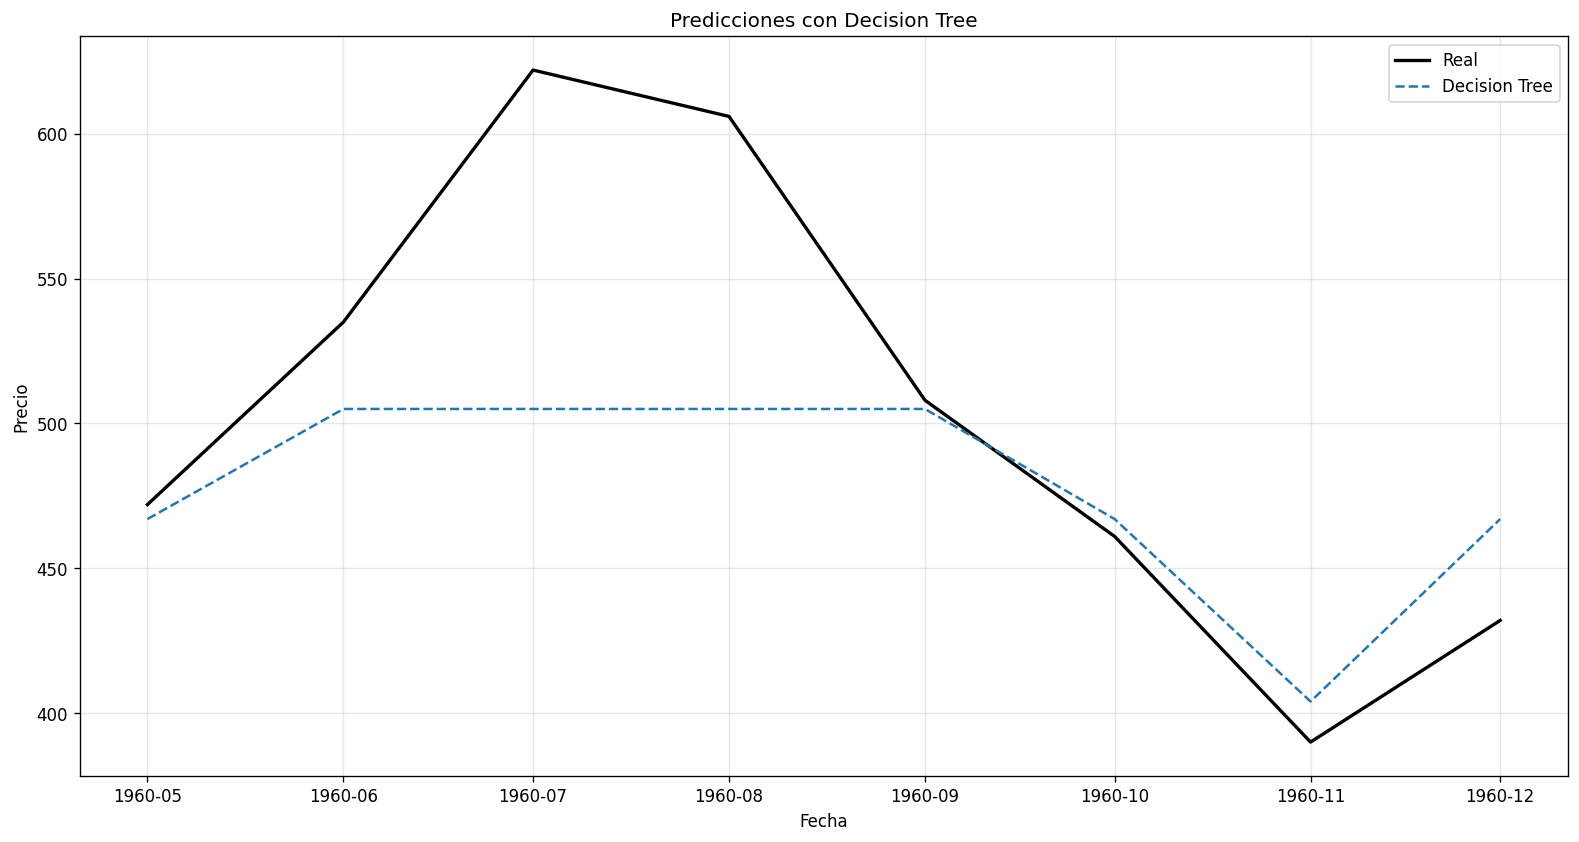

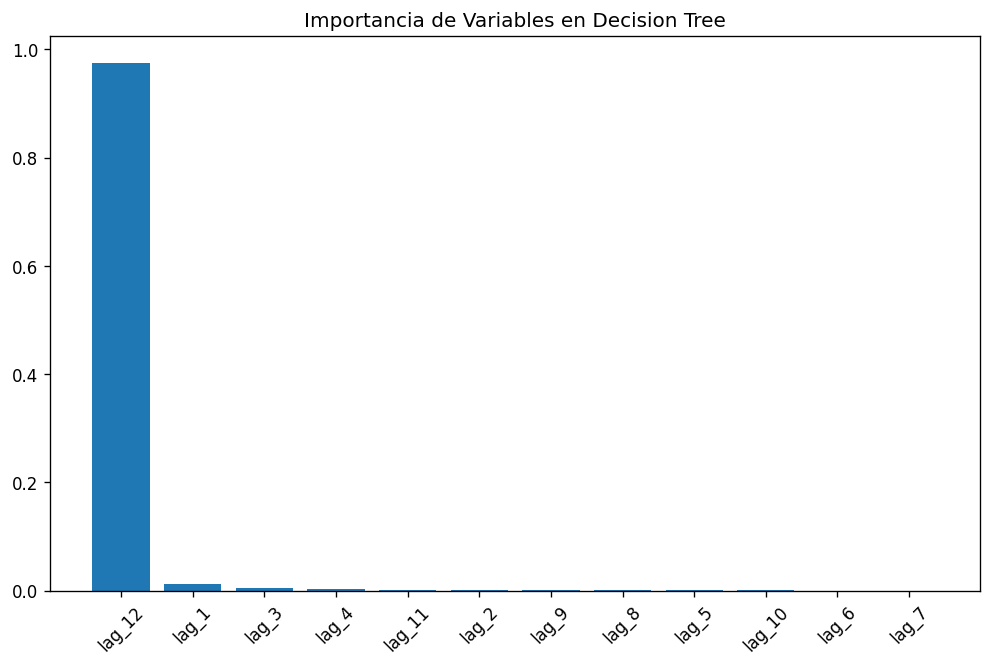

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Función para crear features
def create_features(data, lags=12):
    df = pd.DataFrame(data)
    df.columns = ['y']  # Renombramos la columna
    
    # Creamos los lags
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    
    # Eliminamos las filas con NaN
    df = df.dropna()
    
    # Separamos features (X) y target (y)
    X = df.drop('y', axis=1)
    y = df['y']
    
    return X, y

# Preparamos antes los datos
X_train, y_train = create_features(train.value)
X_test, y_test = create_features(test.value)

print("Shapes de los datos:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Creamos el modelo de Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Calculamos métricas
print("\nMétricas Decision Tree:")
print(f"MAE: {mean_absolute_error(y_test, dt_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, dt_pred)):.2f}")
print(f"R2: {r2_score(y_test, dt_pred):.2f}")

# Visualización
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='Real', color='black', linewidth=2)
plt.plot(y_test.index, dt_pred, label='Decision Tree', linestyle='--')
plt.title('Predicciones con Decision Tree')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Importancia de Variables en Decision Tree')
plt.xticks(rotation=45)
plt.show()